In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
import h5py
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics.pairwise import euclidean_distances
from torch_geometric.nn import SAGEConv, GATConv
from torch_geometric.nn.norm import LayerNorm
from torch.nn import Linear
from itertools import combinations
from PIL import Image
from torch_geometric.nn import knn_graph
from torch_geometric.utils import add_remaining_self_loops
import networkx as nx
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
data_path = r"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/"
df = pd.read_parquet(data_path + "spatially_var_10_patched_df.parquet")

In [11]:
df_train = df[df['set'] == 'train']
df_val = df[df['set'] == 'val']
df_test = df[df['set'] == 'test']

In [12]:
with h5py.File(data_path + "meansize_cells.h5", 'r') as hf:
    cells_arr = np.array(hf['cells'])

<h1>AE GCN</h1>

In [30]:
class cell_autoencoder(nn.Module):
    def __init__(self):
        super(cell_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(), 
            nn.Linear(4*4*256, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 128)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 4*4*256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

feature_extractor = cell_autoencoder()
model_path = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/models/'
checkpoint = torch.load(model_path + "autoencoder.pth", map_location = device)
feature_extractor.load_state_dict(checkpoint['model_state_dict'])
feature_extractor = feature_extractor.to(device)

In [31]:
latent_length = 128
k = 10

In [32]:
test_graphs = []
for patch_index in tqdm(list(set(df_test['patch_index'])), total = len(list(set(df_test['patch_index'])))):
    temp_df = df_test[df_test['patch_index'] == patch_index]
    temp_df = temp_df.reset_index()
                        
    temp_cell_embeds = np.zeros((len(temp_df), latent_length))
    temp_cell_coords = np.zeros((len(temp_df), 2))

    for i, row in temp_df.iterrows():
        cell_tensor = ((torch.from_numpy(cells_arr[row['arr_index']].transpose(2,0,1)).unsqueeze(0).float())/255.0).to(device)
        cell_latent = feature_extractor.encoder(cell_tensor)[0]
        temp_cell_embeds[i] = cell_latent.cpu().detach().numpy()
        temp_cell_coords[i] = np.array((row['x_centroid'], row['y_centroid']))
    
    temp_cell_coords = torch.tensor(temp_cell_coords, dtype=torch.float)
    node_features = torch.tensor(temp_cell_embeds)
    exp = torch.tensor(list(temp_df['gene_exp_vector']))

    G = knn_graph(temp_cell_coords, k=k, batch=None, loop=True)
    G = G.detach().cpu()
    G = add_remaining_self_loops(G)[0]
                        
    temp_graph_data = Data(x = node_features, edge_index = G.cpu(), gene_exp = exp)
    test_graphs.append(temp_graph_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [01:06<00:00,  3.90it/s]


In [33]:
def prepare_data(data):
    data.x = data.x.float()
    data.edge_index = data.edge_index.long()
    data.y = data.gene_exp.float()
    return data
                            
class graph_dataset(InMemoryDataset):
    def __init__(self, graphs):
        self.graphs = graphs
        super(graph_dataset, self).__init__()

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        data = self.graphs[idx]
        return prepare_data(data)

In [34]:
test_dataset = graph_dataset(test_graphs)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [35]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.norms.append(LayerNorm(hidden_channels))

        self.mlp = torch.nn.Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.num_layers):
            x_res = x
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x + x_res) 

        x = self.mlp(x)
        return x

In [36]:
in_channels = 128  #latent rep
hidden_channels = 128
out_channels = 10  #gene exp vector len
num_layers = 3
learning_rate = 0.001
num_epochs = 300

In [37]:
model = GNN(in_channels, hidden_channels, out_channels, num_layers).to(device)

In [38]:
checkpoint = torch.load(model_path + 'ae_gcn_spatial.pth')

In [39]:
checkpoint['loss']

tensor(4.1077e-05, device='cuda:0', requires_grad=True)

In [40]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [41]:
model = model.to(device)

In [42]:
model.eval()

GNN(
  (convs): ModuleList(
    (0-2): 3 x SAGEConv(128, 128, aggr=mean)
  )
  (norms): ModuleList(
    (0-2): 3 x LayerNorm(128, affine=True, mode=graph)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [43]:
true_vectors = []
predicted_vectors = []
for data in tqdm(test_loader, total = len(test_loader)):
    data = data.to(device)
    for vector in data.y:
        true_vectors.append(vector.cpu().detach().numpy())
    for vector in model(data):
        predicted_vectors.append(vector.cpu().detach().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 11.69it/s]


In [44]:
true_vectors = np.array(true_vectors)
predicted_vectors = np.array(predicted_vectors)

In [45]:
print(true_vectors.shape)
print(predicted_vectors.shape)

(84283, 10)
(84283, 10)


In [46]:
from scipy.stats import spearmanr

spearman_correlations_ae = []

for i in range (len(true_vectors[0])):
    temp_gene_true = []
    temp_gene_pred = []
    for true_vector, predicted_vector in zip(true_vectors, predicted_vectors):
        temp_gene_true.append(true_vector[i])
        temp_gene_pred.append(predicted_vector[i])
    spearman_correlations_ae.append(float(spearmanr(temp_gene_true, temp_gene_pred)[0]))

In [47]:
predicted_vectors[0]

array([-3.5537034e-04, -9.4076619e-05,  4.2462796e-03,  7.9563633e-04,
        5.0235838e-03,  6.0322508e-04,  2.4031997e-03, -2.8848276e-04,
        7.2486699e-05,  1.4238320e-03], dtype=float32)

In [48]:
true_vectors[0]

array([0.        , 0.        , 0.00477328, 0.        , 0.00477328,
       0.        , 0.00952388, 0.        , 0.        , 0.        ],
      dtype=float32)

{'whiskers': [<matplotlib.lines.Line2D at 0x1509a36cf150>,
 'caps': [<matplotlib.lines.Line2D at 0x1509829ac6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1509a36cfb90>],
 'medians': [<matplotlib.lines.Line2D at 0x1509acfaca90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1509acfc1a90>],
 'means': []}

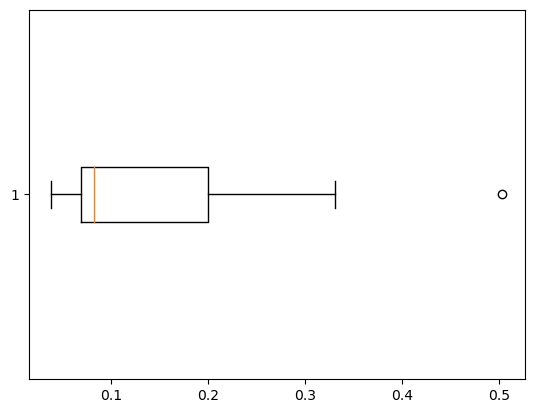

In [49]:
plt.boxplot(spearman_correlations_ae, vert = False)

<h1>ResNet GCN</h1>

In [13]:
resnet = models.resnet50(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_ftrs, 128),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(128, 10),
               )
model_path = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/models/'
checkpoint = torch.load(model_path + "resnet50_spatial_feature_0.00001.pth", map_location = device)
resnet.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['loss'])
                            
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.add_module('fc', nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
))
feature_extractor = feature_extractor.to(device)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


4.115230403078506e-05


In [14]:
latent_length = 128
k = 10

In [15]:
test_graphs = []
for patch_index in tqdm(list(set(df_test['patch_index'])), total = len(list(set(df_test['patch_index'])))):
    temp_df = df_test[df_test['patch_index'] == patch_index]
    temp_df = temp_df.reset_index()
                        
    temp_cell_embeds = np.zeros((len(temp_df), latent_length))
    temp_cell_coords = np.zeros((len(temp_df), 2))

    for i, row in temp_df.iterrows():
        cell_tensor = ((torch.from_numpy(cells_arr[row['arr_index']].transpose(2,0,1)).unsqueeze(0).float())/255.0).to(device)
        cell_latent = feature_extractor(cell_tensor)[0]
        temp_cell_embeds[i] = cell_latent.cpu().detach().numpy()
        temp_cell_coords[i] = np.array((row['x_centroid'], row['y_centroid']))
    
    temp_cell_coords = torch.tensor(temp_cell_coords, dtype=torch.float)
    node_features = torch.tensor(temp_cell_embeds)
    exp = torch.tensor(list(temp_df['gene_exp_vector']))

    G = knn_graph(temp_cell_coords, k=k, batch=None, loop=True)
    G = G.detach().cpu()
    G = add_remaining_self_loops(G)[0]
                        
    temp_graph_data = Data(x = node_features, edge_index = G.cpu(), gene_exp = exp)
    test_graphs.append(temp_graph_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [10:11<00:00,  2.34s/it]


In [16]:
def prepare_data(data):
    data.x = data.x.float()
    data.edge_index = data.edge_index.long()
    data.y = data.gene_exp.float()
    return data
                            
class graph_dataset(InMemoryDataset):
    def __init__(self, graphs):
        self.graphs = graphs
        super(graph_dataset, self).__init__()

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        data = self.graphs[idx]
        return prepare_data(data)

In [17]:
test_dataset = graph_dataset(test_graphs)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.norms.append(LayerNorm(hidden_channels))

        self.mlp = torch.nn.Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.num_layers):
            x_res = x
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x + x_res) 

        x = self.mlp(x)
        return x

In [19]:
in_channels = 128  #latent rep
hidden_channels = 128
out_channels = 10  #gene exp vector len
num_layers = 3
learning_rate = 0.001
num_epochs = 300

In [20]:
model = GNN(in_channels, hidden_channels, out_channels, num_layers).to(device)

In [21]:
checkpoint = torch.load(model_path + 'renet_gcn_spatial.pth')
checkpoint['loss']

tensor(4.5649e-05, device='cuda:0', requires_grad=True)

In [22]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

GNN(
  (convs): ModuleList(
    (0-2): 3 x SAGEConv(128, 128, aggr=mean)
  )
  (norms): ModuleList(
    (0-2): 3 x LayerNorm(128, affine=True, mode=graph)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [23]:
true_vectors_resnet = []
predicted_vectors_resnet = []
for data in tqdm(test_loader, total = len(test_loader)):
    data = data.to(device)
    for vector in data.y:
        true_vectors_resnet.append(vector.cpu().detach().numpy())
    for vector in model(data):
        predicted_vectors_resnet.append(vector.cpu().detach().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.90it/s]


In [24]:
true_vectors_resnet = np.array(true_vectors_resnet)
predicted_vectors_resnet = np.array(predicted_vectors_resnet)

In [25]:
print(true_vectors_resnet.shape)
print(predicted_vectors_resnet.shape)

(84283, 10)
(84283, 10)


In [26]:
from scipy.stats import spearmanr

spearman_correlations_resnet = []

for i in range (len(true_vectors_resnet[0])):
    temp_gene_true = []
    temp_gene_pred = []
    for true_vector, predicted_vector in zip(true_vectors_resnet, predicted_vectors_resnet):
        temp_gene_true.append(true_vector[i])
        temp_gene_pred.append(predicted_vector[i])
    spearman_correlations_resnet.append(float(spearmanr(temp_gene_true, temp_gene_pred)[0]))

In [27]:
predicted_vectors_resnet[0]

array([-0.02550197,  0.01152841,  0.01772287,  0.02692446,  0.00460328,
       -0.00272197,  0.03903307, -0.02095724, -0.01408584,  0.00326041],
      dtype=float32)

In [28]:
true_vectors_resnet[0]

array([0.        , 0.        , 0.        , 0.        , 0.00524936,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

{'whiskers': [<matplotlib.lines.Line2D at 0x1509a372d650>,
 'caps': [<matplotlib.lines.Line2D at 0x1509a3772f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1509acf55e90>],
 'medians': [<matplotlib.lines.Line2D at 0x1509a374c810>],
 'fliers': [<matplotlib.lines.Line2D at 0x1509a374d650>],
 'means': []}

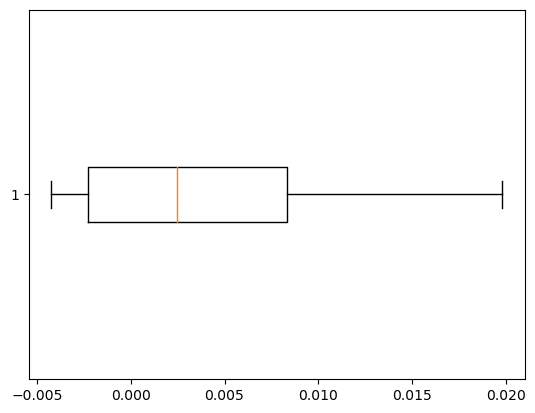

In [29]:
plt.boxplot(spearman_correlations_resnet, vert = False)

<h1>CNN GCN</h1>

In [56]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 4 * 4)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
#         x = self.fc3(x)
        
        return x

feature_extractor = CNN()
model_path = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/models/'
checkpoint = torch.load(model_path + "scratch_cnn_lr_sched.pth", map_location = device)
feature_extractor.load_state_dict(checkpoint['model_state_dict'])
feature_extractor = feature_extractor.to(device)

In [57]:
latent_length = 128
k = 10

In [58]:
test_graphs = []
for patch_index in tqdm(list(set(df_test['patch_index'])), total = len(list(set(df_test['patch_index'])))):
    temp_df = df_test[df_test['patch_index'] == patch_index]
    temp_df = temp_df.reset_index()
                        
    temp_cell_embeds = np.zeros((len(temp_df), latent_length))
    temp_cell_coords = np.zeros((len(temp_df), 2))

    for i, row in temp_df.iterrows():
        cell_tensor = ((torch.from_numpy(cells_arr[row['arr_index']].transpose(2,0,1)).unsqueeze(0).float())/255.0).to(device)
        cell_latent = feature_extractor(cell_tensor)[0]
        temp_cell_embeds[i] = cell_latent.cpu().detach().numpy()
        temp_cell_coords[i] = np.array((row['x_centroid'], row['y_centroid']))
    
    temp_cell_coords = torch.tensor(temp_cell_coords, dtype=torch.float)
    node_features = torch.tensor(temp_cell_embeds)
    exp = torch.tensor(list(temp_df['gene_exp_vector']))

    G = knn_graph(temp_cell_coords, k=k, batch=None, loop=True)
    G = G.detach().cpu()
    G = add_remaining_self_loops(G)[0]
                        
    temp_graph_data = Data(x = node_features, edge_index = G.cpu(), gene_exp = exp)
    test_graphs.append(temp_graph_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [03:45<00:00,  1.16it/s]


In [62]:
def prepare_data(data):
    data.x = data.x.float()
    data.edge_index = data.edge_index.long()
    data.y = data.gene_exp.float()
    return data
                            
class graph_dataset(InMemoryDataset):
    def __init__(self, graphs):
        self.graphs = graphs
        super(graph_dataset, self).__init__()

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        data = self.graphs[idx]
        return prepare_data(data)

In [63]:
test_dataset = graph_dataset(test_graphs)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/AshankS/anaconda3/envs/Ashank/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [64]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.norms.append(LayerNorm(hidden_channels))

        self.mlp = torch.nn.Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.num_layers):
            x_res = x
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x + x_res) 

        x = self.mlp(x)
        return x

In [65]:
# Hyperparameters
in_channels = 128  #latent rep
hidden_channels = 128
out_channels = 10  #gene exp vector len
num_layers = 3
learning_rate = 0.001
num_epochs = 300

In [66]:
model = GNN(in_channels, hidden_channels, out_channels, num_layers).to(device)

In [67]:
checkpoint = torch.load(model_path + 'cnn_gcn_spatial.pth')
checkpoint['loss']

tensor(4.2050e-05, device='cuda:0', requires_grad=True)

In [68]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

GNN(
  (convs): ModuleList(
    (0-2): 3 x SAGEConv(128, 128, aggr=mean)
  )
  (norms): ModuleList(
    (0-2): 3 x LayerNorm(128, affine=True, mode=graph)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [69]:
true_vectors_cnn = []
predicted_vectors_cnn = []
for data in tqdm(test_loader, total = len(test_loader)):
    data = data.to(device)
    for vector in data.y:
        true_vectors_cnn.append(vector.cpu().detach().numpy())
    for vector in model(data):
        predicted_vectors_cnn.append(vector.cpu().detach().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 12.10it/s]


In [70]:
true_vectors_cnn = np.array(true_vectors_cnn)
predicted_vectors_cnn = np.array(predicted_vectors_cnn)

In [71]:
from scipy.stats import spearmanr

spearman_correlations_cnn = []

for i in range (len(true_vectors_cnn[0])):
    temp_gene_true = []
    temp_gene_pred = []
    for true_vector, predicted_vector in zip(true_vectors_cnn, predicted_vectors_cnn):
        temp_gene_true.append(true_vector[i])
        temp_gene_pred.append(predicted_vector[i])
    spearman_correlations_cnn.append(float(spearmanr(temp_gene_true, temp_gene_pred)[0]))

In [72]:
predicted_vectors_cnn[0]

array([ 1.0044500e-03, -5.4214895e-04,  4.5634359e-03,  1.8365718e-03,
        5.3878175e-03,  4.8104674e-05,  1.8273145e-03,  8.9634955e-04,
       -6.1549246e-04,  1.9048899e-03], dtype=float32)

In [73]:
true_vectors_cnn[0]

array([0.        , 0.        , 0.00579712, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

{'whiskers': [<matplotlib.lines.Line2D at 0x147326e079d0>,
 'caps': [<matplotlib.lines.Line2D at 0x147326e75150>,
 'boxes': [<matplotlib.lines.Line2D at 0x147326fa61d0>],
 'medians': [<matplotlib.lines.Line2D at 0x147326e766d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1472c6777090>],
 'means': []}

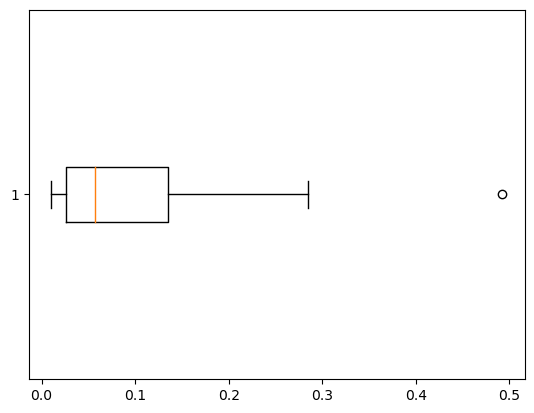

In [76]:
plt.boxplot(spearman_correlations_cnn, vert = False)

<h1>Final Figure</h1>

{'whiskers': [<matplotlib.lines.Line2D at 0x147326ea65d0>,
 'caps': [<matplotlib.lines.Line2D at 0x147326ea4210>,
 'boxes': [<matplotlib.lines.Line2D at 0x147326ea7c90>,
 'medians': [<matplotlib.lines.Line2D at 0x147326e2f710>,
 'fliers': [<matplotlib.lines.Line2D at 0x147326eb4cd0>,
 'means': []}

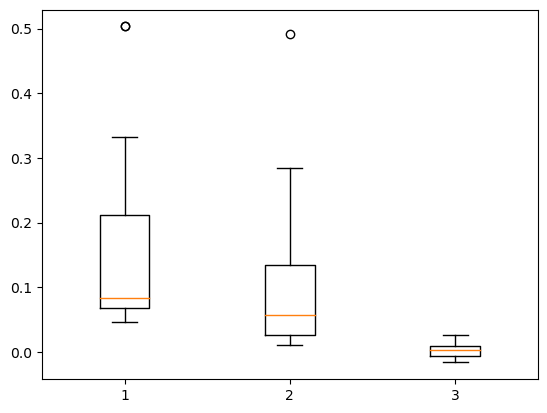

In [78]:
plt.boxplot([spearman_correlations_ae, spearman_correlations_cnn, spearman_correlations_resnet])

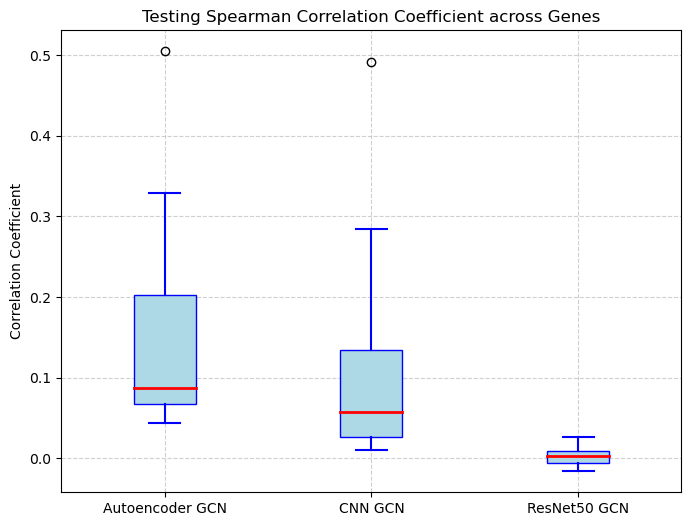

In [110]:
plt.figure(figsize=(8, 6))
plt.boxplot([spearman_correlations_ae, spearman_correlations_cnn, spearman_correlations_resnet], positions=[1, 2, 3], widths=0.3, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue', linewidth=1.5),
            capprops=dict(color='blue', linewidth=1.5))

plt.xticks([1, 2, 3], ['Autoencoder GCN', 'CNN GCN', 'ResNet50 GCN'])
plt.title('Testing Spearman Correlation Coefficient across Genes')
plt.ylabel('Correlation Coefficient')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [107]:
np.mean(spearman_correlations_ae)

0.16305211870489353

In [108]:
np.mean(spearman_correlations_cnn)

0.12359261566337199

In [109]:
np.mean(spearman_correlations_resnet)

0.002260833296898062

<h1>Heatmaps</h1>

In [51]:
test_graphs[0]

Data(x=[177, 128], edge_index=[2, 1770], gene_exp=[177, 10], y=[177, 10])

In [55]:
import networkx as nx
from torch_geometric.utils import to_networkx

In [141]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_gene_heatmap_points(data, gene_exp_pred = None):
    G = to_networkx(data, to_undirected=True, node_attrs=None, edge_attrs=None)
    
    gene_expression_pred = gene_exp_pred[:, 9].numpy()
    gene_expression = data.gene_exp[:, 9].numpy()
    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G) 
    x_coords, y_coords = zip(*pos.values())  
    plt.scatter(x_coords, y_coords, c=gene_expression, cmap='viridis', s=100)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gene_expression.min(), vmax=gene_expression.max()))
    sm.set_array([])
    plt.colorbar(sm, label="Gene Expression Level")
    plt.title("Ground Truth Node Visualization SFRP4 Expression Heatmap")
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.scatter(x_coords, y_coords, c=gene_expression_pred, cmap='viridis', s=100)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gene_expression.min(), vmax=gene_expression.max()))
    sm.set_array([])
    plt.colorbar(sm, label="Gene Expression Level")
    plt.title("Predicted Node Visualization SFRP4 Expression Heatmap")
    plt.show()


In [142]:
spearman_correlations_ae

[0.20937450352825568,
 0.04633060009200815,
 0.0848059685794723,
 0.07999357323181236,
 0.33060736194904317,
 0.03817657671819417,
 0.0673463444286066,
 0.1720962236894211,
 0.07515258635326678,
 0.5033416684299117]

In [195]:
temp_graph = test_graphs[18]

In [196]:
pred = model(temp_graph.to(device))

/scratch/ipykernel_2638369/960286063.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Gene Expression Level")


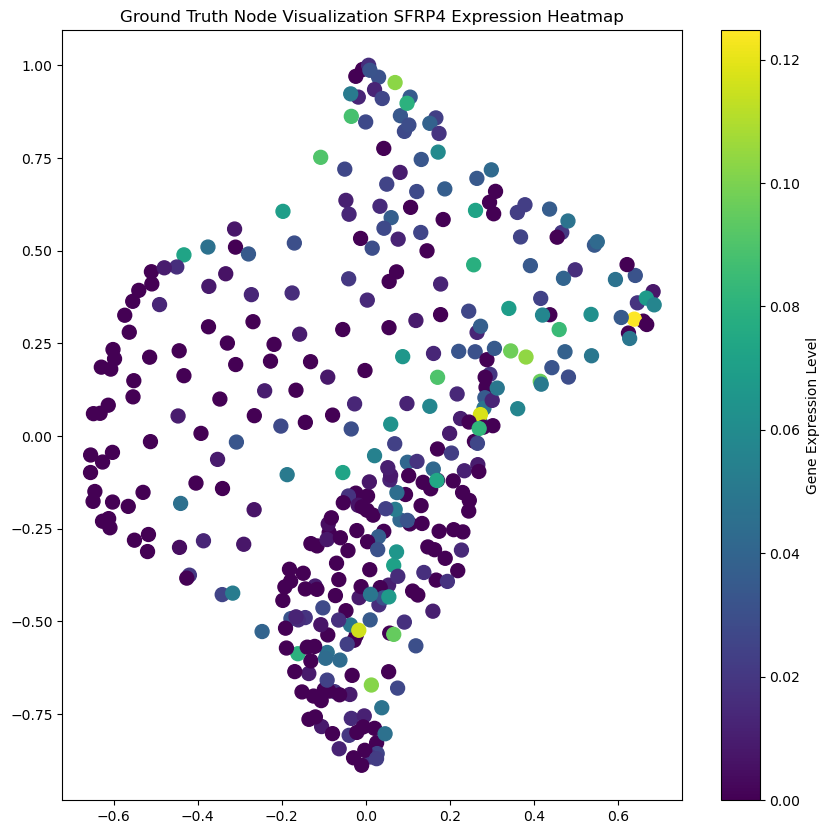

/scratch/ipykernel_2638369/960286063.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Gene Expression Level")


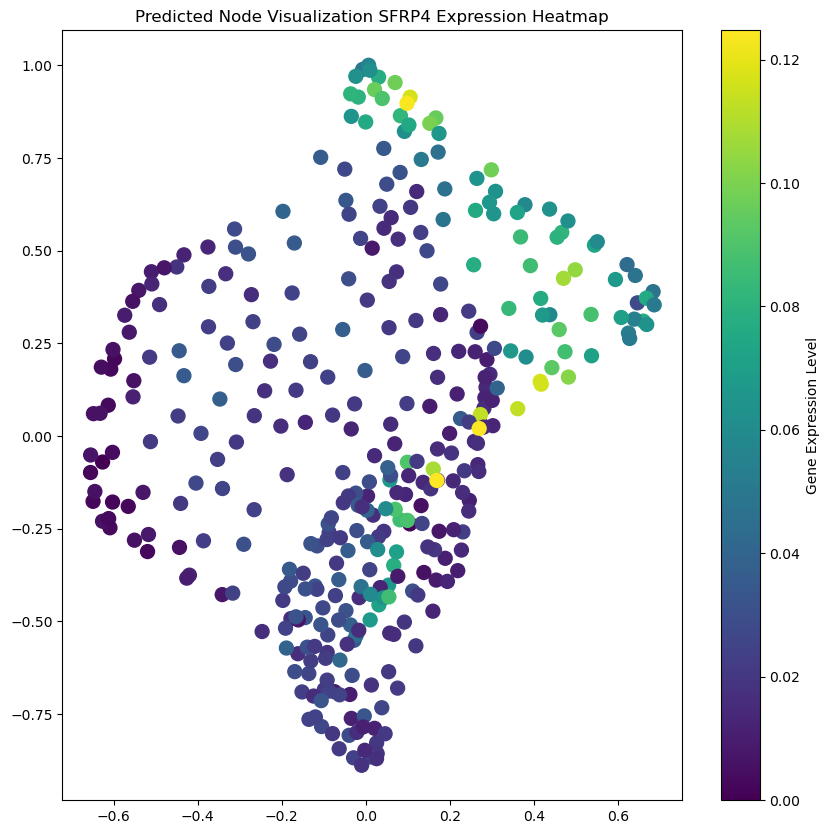

In [197]:
visualize_gene_heatmap_points(temp_graph.to(torch.device('cpu')), pred.cpu().detach())

In [139]:
df = pd.read_parquet("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/spatialde_results_128_sorted.parquet")
df.head(10)

,g,l,qval
index,,,
242,SERPINB9,584.234251,0.0
253,SNAI1,584.234251,0.0
252,SMS,584.234251,0.0
251,SMAP2,584.234251,0.0
250,SLC5A6,584.234251,0.0
249,SLC26A3,584.234251,0.0
248,SLC25A37,584.234251,0.0
247,SLAMF7,584.234251,0.0
246,SLAMF1,584.234251,0.0
